In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import matplotlib
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
SEED = 27
N_SPLITS = 10
N_REPEATS = 5

# Loading Data

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv', index_col='id')

original = pd.read_csv('/kaggle/input/abalone-dataset/abalone.csv')

In [4]:
train.describe()

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [5]:
train.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
id,,,,,,,,,
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


# Preprocessing

In [6]:
original.index.name = 'id'
original = original.rename(columns={
    'Shucked weight': 'Whole weight.1',
    'Viscera weight': 'Whole weight.2',
})

train['Sex'] = train['Sex'].map({'M': 0, 'F': 1, 'I': 2})
test['Sex'] = test['Sex'].map({'M': 0, 'F': 1, 'I': 2})
original['Sex'] = original['Sex'].map({'M': 0, 'F': 1, 'I': 2})

numerical_features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']

In [7]:
X = train.drop(columns='Rings')
y = train['Rings']

# Exploring the Dataset

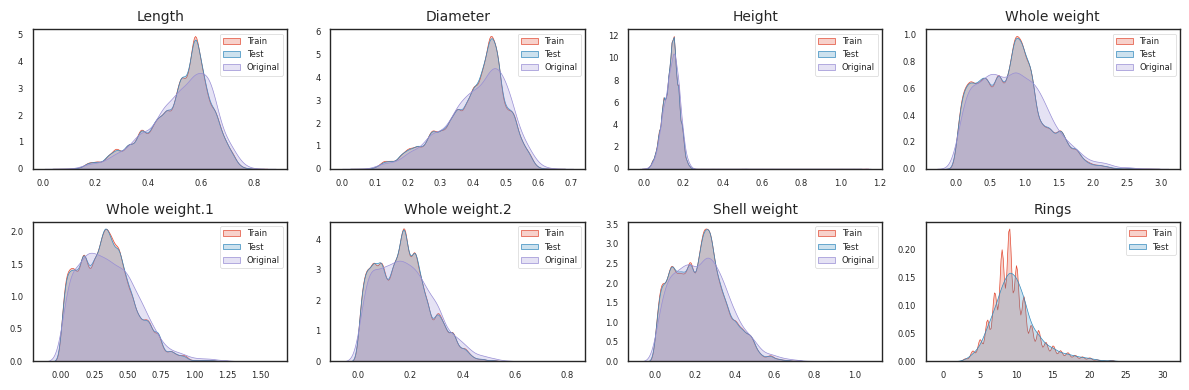

In [8]:
sns.set_style("white")
fig, axes = plt.subplots(2, 4, figsize=(12, 4))
for i, col in enumerate(numerical_features + ['Rings']):
    sns.kdeplot(data=train, x=col, ax=axes[i // 4, i % 4], fill=True)
    if col != 'Rings':
        sns.kdeplot(data=test, x=col, ax=axes[i // 4, i % 4], fill=True)
    sns.kdeplot(data=original, x=col, ax=axes[i // 4, i % 4], fill=True)
    axes[i // 4, i % 4].set_title(col, fontsize=10)
    axes[i // 4, i % 4].set_xlabel('')
    axes[i // 4, i % 4].set_ylabel('')
    axes[i // 4, i % 4].tick_params(axis='both', which='major', labelsize=6)
    axes[i // 4, i % 4].legend(['Train', 'Test', 'Original'], loc='best', fontsize=6)
    
plt.tight_layout()
plt.show()

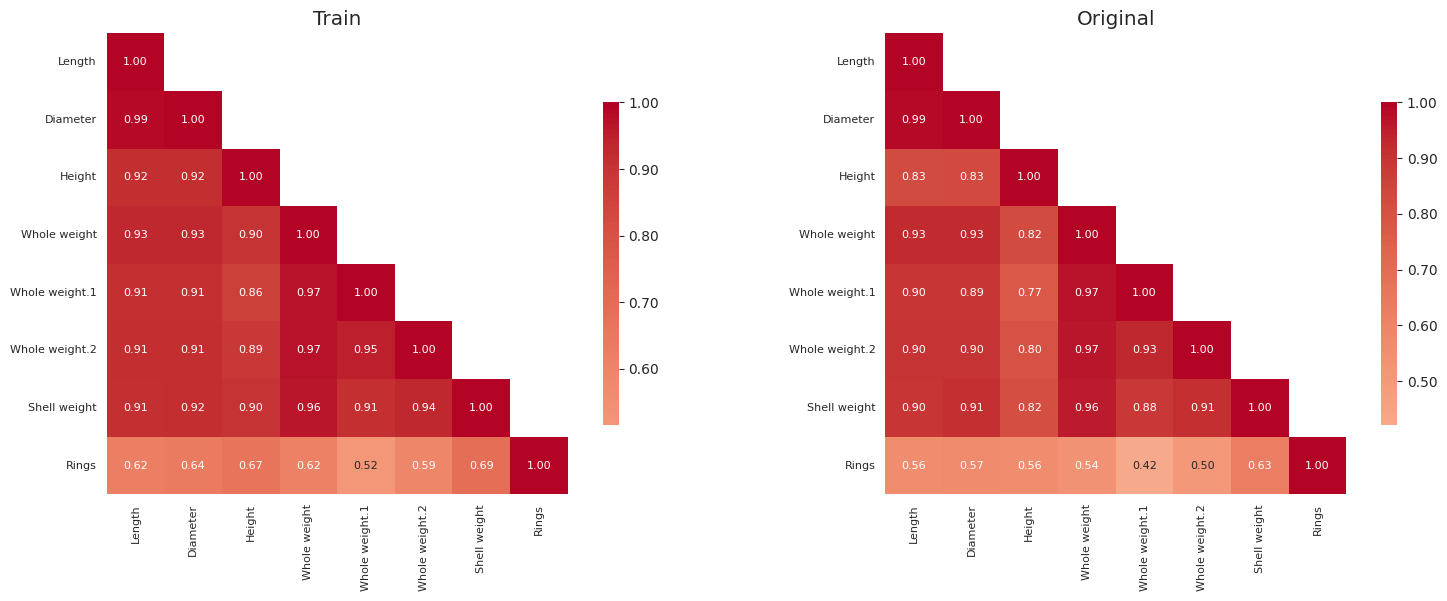

In [9]:
sns.set_style("white")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

corr_train = train[numerical_features + ['Rings']].corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)
sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.2f',
    mask=mask_train,
    square=True,
    cmap='coolwarm',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=axes[0]
)
axes[0].set_title('Train')
axes[0].tick_params(axis='both', which='major', labelsize=8)

corr_orig = original[numerical_features + ['Rings']].corr()
mask_orig = np.triu(np.ones_like(corr_orig, dtype=bool), k=1)
sns.heatmap(
    data=corr_orig,
    annot=True,
    fmt='.2f',
    mask=mask_orig,
    square=True,
    cmap='coolwarm',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=axes[1]
)
axes[1].set_title('Original')
axes[1].tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

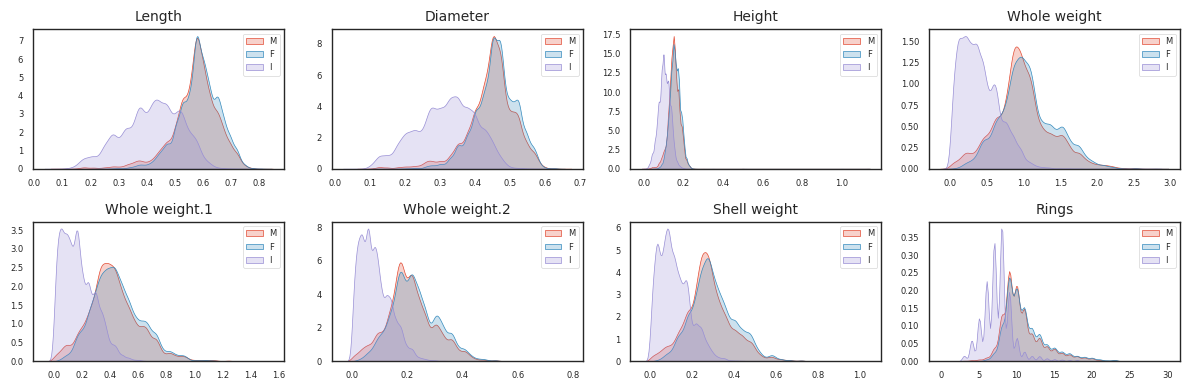

In [10]:
sns.set_style("white")
fig, axes = plt.subplots(2, 4, figsize=(12, 4))
for i, col in enumerate(numerical_features + ['Rings']):
    sns.kdeplot(data=train[train['Sex'] == 0], x=col, ax=axes[i // 4, i % 4], fill=True)
    sns.kdeplot(data=train[train['Sex'] == 1], x=col, ax=axes[i // 4, i % 4], fill=True)
    sns.kdeplot(data=train[train['Sex'] == 2], x=col, ax=axes[i // 4, i % 4], fill=True)
    axes[i // 4, i % 4].set_title(col, fontsize=10)
    axes[i // 4, i % 4].set_xlabel('')
    axes[i // 4, i % 4].set_ylabel('')
    axes[i // 4, i % 4].tick_params(axis='both', which='major', labelsize=6)
    axes[i // 4, i % 4].legend(['M', 'F', 'I'], loc='best', fontsize=6)
    
plt.tight_layout()
plt.show()

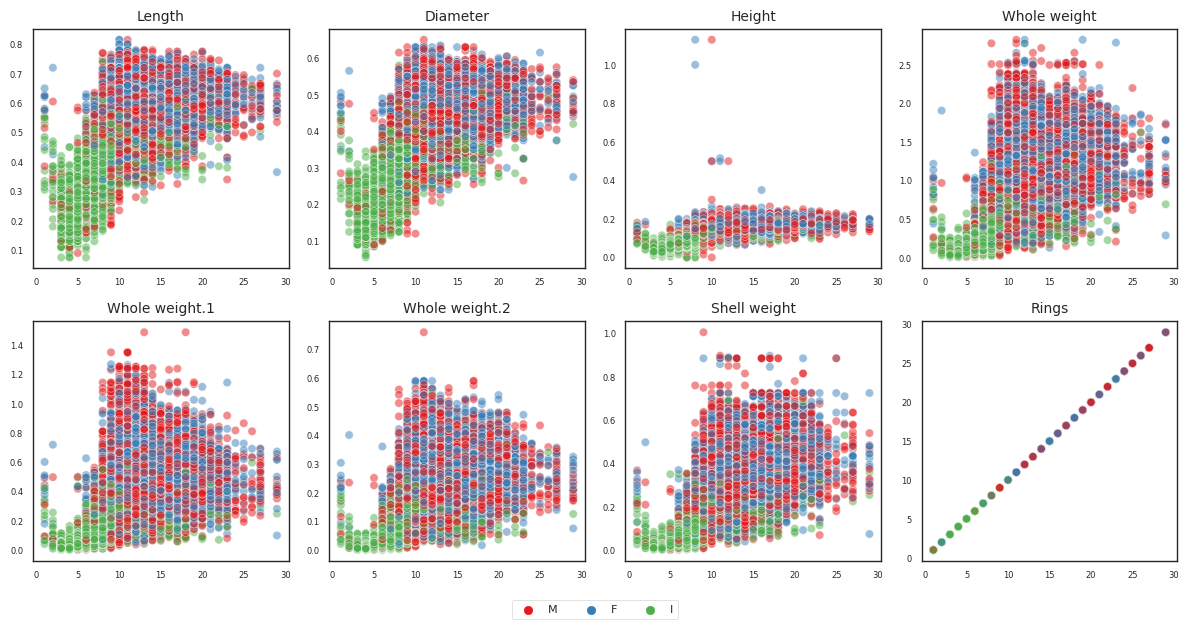

In [11]:
sns.set_style("white")
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, col in enumerate(numerical_features + ['Rings']):
    scatter = sns.scatterplot(data=train, x=train['Rings'], y=train[col], hue='Sex', ax=axes[i // 4, i % 4], alpha=0.5, palette='Set1')
    axes[i // 4, i % 4].set_title(col, fontsize=10)
    axes[i // 4, i % 4].set_xlabel('')
    axes[i // 4, i % 4].set_ylabel('')
    axes[i // 4, i % 4].tick_params(axis='both', which='major', labelsize=6)
    axes[i // 4, i % 4].get_legend().remove()

handles, labels = scatter.get_legend_handles_labels()
fig.legend(handles=handles, labels=['M', 'F', 'I'], loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05), fontsize=8)

plt.tight_layout()
plt.show()

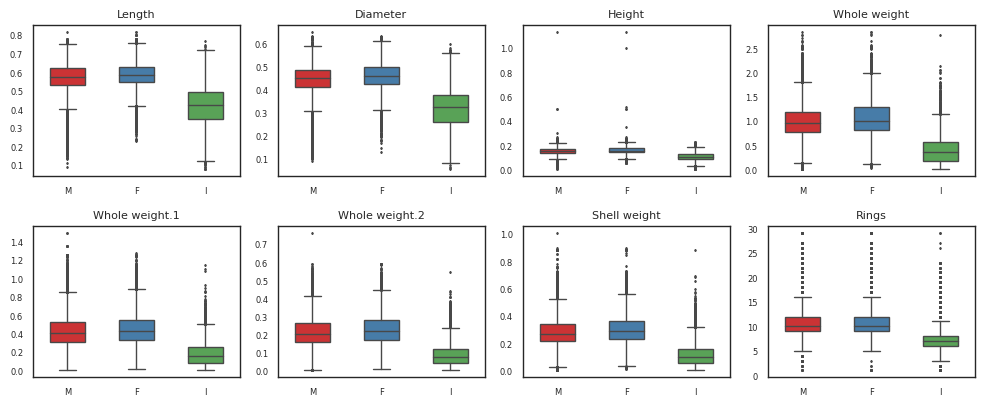

In [12]:
sns.set_style("white")
fig = plt.figure(figsize=[10, 8])
fig.subplots_adjust(top=0.92, hspace=0.5, wspace=0.4)

for i, col in enumerate(numerical_features + ['Rings']):
    ax = fig.add_subplot(4, 4, i+1)
    sns.boxplot(data=train, y=col, x='Sex', ax=ax, palette='Set1', linewidth=1, fliersize=1, width=0.5)
    ax.set_title(col, fontsize=8)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_xticklabels(['M', 'F', 'I'])

plt.tight_layout()
plt.show()

# Defining CV & Training Function

In [13]:
def train(model, X, y, n_splits=N_SPLITS, n_repeats=N_REPEATS):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    oof_preds = np.zeros(len(X), dtype=float)
    scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        y_pred = np.zeros_like(y_val, dtype=float)
        
        for i in range(n_repeats):
            m = clone(model)
            if n_repeats > 1:
                m.regressor.set_params(random_state=i)
            m.fit(X_train, y_train)
            y_pred += m.predict(X_val)
            
        y_pred /= n_repeats
        y_pred = y_pred.clip(1, 29)
        
        score = mean_squared_log_error(y_val, y_pred, squared=False)
        scores.append(score)
        
        oof_preds[val_idx] = y_pred
        
    return scores, oof_preds
    
def predict(model, X, y, X_test, n_repeats=N_REPEATS):
    y_pred = np.zeros(len(X_test), dtype=float)
    for i in range(n_repeats):
        m = clone(model)
        if n_repeats > 1:
            m.regressor.set_params(random_state=i)
        m.fit(X, y)
        y_pred += m.predict(X_test)
    y_pred /= n_repeats
    y_pred = y_pred.clip(1, 29)
    return y_pred

# Training Base Models

In [14]:
models = [
    CatBoostRegressor(random_state=SEED, verbose=False),
    LGBMRegressor(random_state=SEED, verbose=-1),
    RandomForestRegressor(random_state=SEED, n_jobs=-1),
    GradientBoostingRegressor(random_state=SEED),
    KNeighborsRegressor(n_jobs=-1),
    XGBRegressor(random_state=SEED, n_jobs=-1),
    HistGradientBoostingRegressor(random_state=SEED),
    ExtraTreesRegressor(random_state=SEED, n_jobs=-1),
    DecisionTreeRegressor(random_state=SEED),
    ExtraTreeRegressor(random_state=SEED),
    LinearRegression(n_jobs=-1),
    SGDRegressor(random_state=SEED),
]

In [15]:
model_scores = {}
model_preds = {}
for estimator in models:
    model = TransformedTargetRegressor(
        regressor=estimator,
        func=np.log1p,
        inverse_func=np.expm1
    )

    if estimator.__class__.__name__ in ["KNeighborsRegressor", "LinearRegression"]:
        n_repeats = 1
    else:
        n_repeats = N_REPEATS

    scores, preds = train(model, X, y, N_SPLITS, n_repeats)
    model_scores[estimator.__class__.__name__] = scores
    model_preds[estimator.__class__.__name__] = preds
    print(f'\t{estimator.__class__.__name__}: {np.mean(scores):.5f} ± {np.std(scores):.5f}')

	CatBoostRegressor: 0.14850 ± 0.00148
	LGBMRegressor: 0.14962 ± 0.00136
	RandomForestRegressor: 0.15197 ± 0.00150
	GradientBoostingRegressor: 0.15275 ± 0.00142
	KNeighborsRegressor: 0.16282 ± 0.00143
	XGBRegressor: 0.15017 ± 0.00136
	HistGradientBoostingRegressor: 0.14967 ± 0.00136
	ExtraTreesRegressor: 0.15290 ± 0.00169
	DecisionTreeRegressor: 0.20822 ± 0.00200
	ExtraTreeRegressor: 0.16878 ± 0.00179
	LinearRegression: 0.16475 ± 0.00151
	SGDRegressor: 0.17504 ± 0.00106


# Results

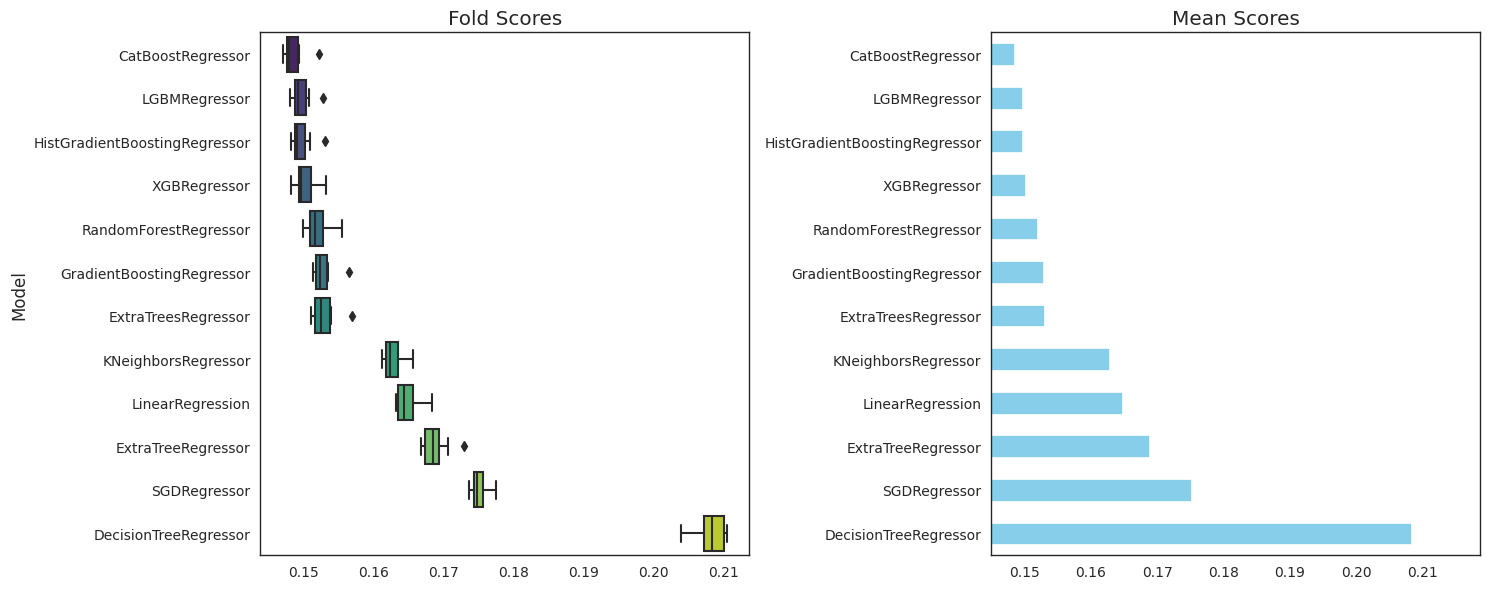

In [16]:
model_scores_df = pd.DataFrame(model_scores)

sns.set_style("white")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(data=model_scores_df, orient='h', palette='viridis', ax=axes[0], order=model_scores_df.mean().sort_values().index.tolist())
axes[0].set_title('Fold Scores')
axes[0].set_xlabel('')
axes[0].set_ylabel('Model')

mean_scores = model_scores_df.mean().sort_values(ascending=False)
mean_scores.plot(kind='barh', ax=axes[1], color='skyblue')
axes[1].set_title('Mean Scores')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xlim(left=0.145)

plt.tight_layout()
plt.show()

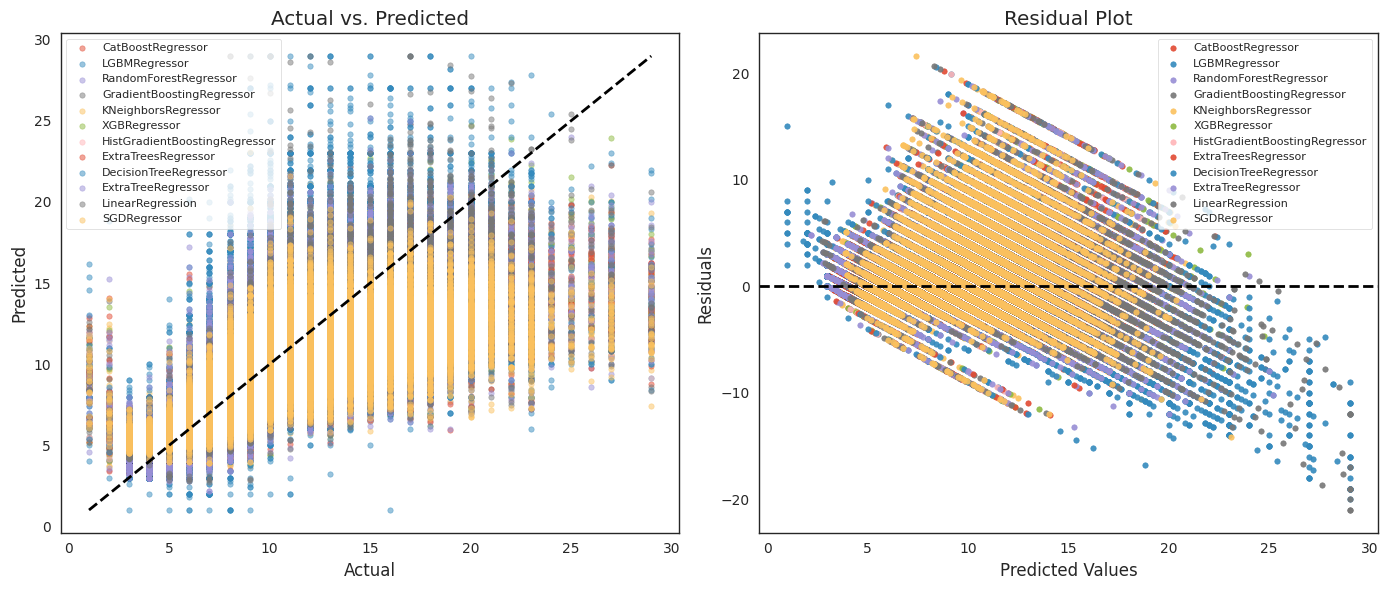

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for model_name, model_pred in model_preds.items():
    axes[0].scatter(y, model_pred, alpha=0.5, s=15, label=model_name)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title('Actual vs. Predicted')
axes[0].legend(loc='best', fontsize=8)

for model_name, model_pred in model_preds.items():
    axes[1].scatter(model_pred, y - model_pred, alpha=0.9, s=15, label=model_name)
axes[1].axhline(y=0, color='black', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].legend(loc='best', fontsize=8)

plt.tight_layout()
plt.show()

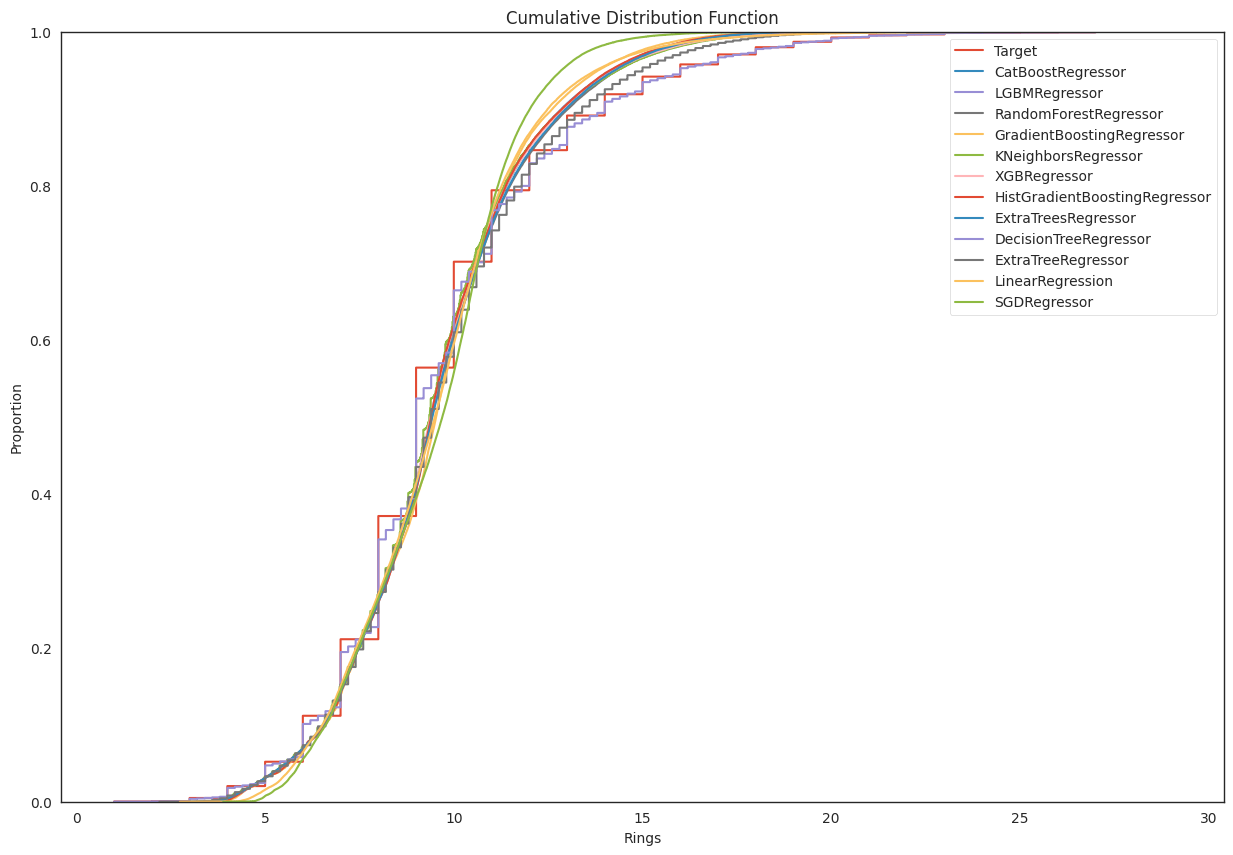

In [18]:
sns.set_style("white")
fig = plt.figure(figsize=[15, 10])

sns.ecdfplot(data=y, stat='proportion', complementary=False, label='Target')
for model, preds in model_preds.items():
    sns.ecdfplot(data=preds, stat='proportion', complementary=False, label=model)

plt.title('Cumulative Distribution Function', fontsize=12)
plt.xlabel('Rings', fontsize=10)
plt.ylabel('Proportion', fontsize=10)
plt.legend()
plt.show()

I will use Cumulative Distribution Function (CDF) to select models for an ensemble (idea from [this post](https://www.kaggle.com/competitions/playground-series-s4e4/discussion/494165))

### Observation from the CDFs
- Most of the models have similar CDFs, specially tree based models. I have previously ensembled XGBoost, Catboost and LightGBM but looking at their CDFs, their predictions are almost identical across all the ranges.
- Most models overpredict the higher ranges except for DecisionTreeRegressor and ExtraTreeRegressor.

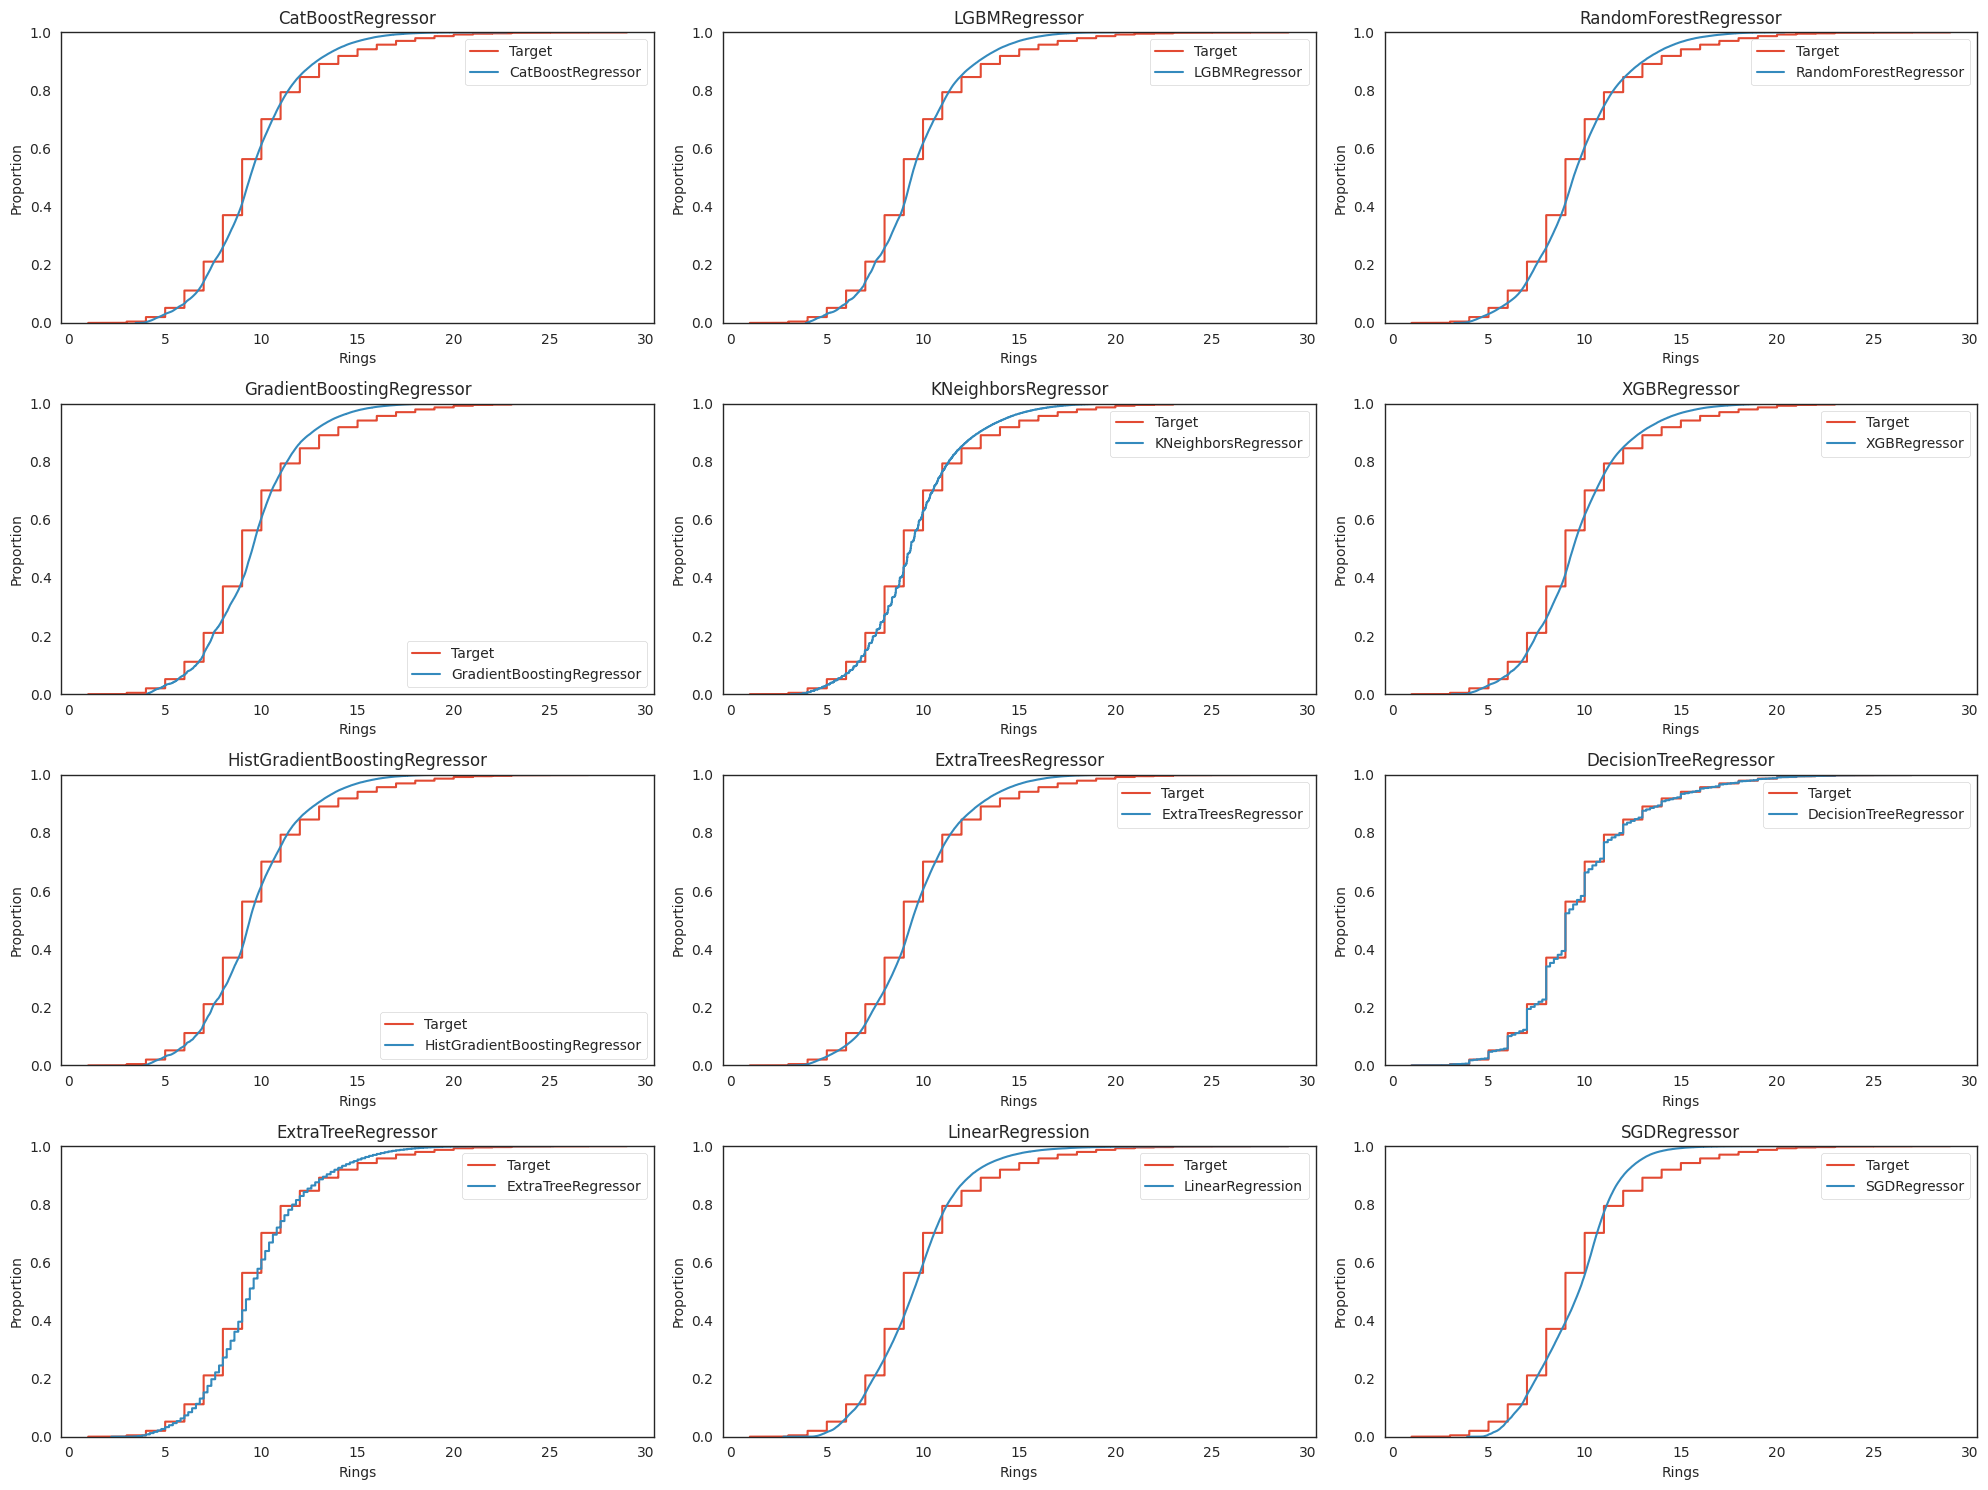

In [19]:
sns.set_style("white")
fig, axs = plt.subplots(4, 3, figsize=[20, 15])

axs = axs.flatten()

for ax, (model, preds) in zip(axs, model_preds.items()):
    sns.ecdfplot(data=y, stat='proportion', complementary=False, label='Target', ax=ax)
    sns.ecdfplot(data=preds, stat='proportion', complementary=False, label=model, ax=ax)
    ax.set_title(model, fontsize=12)
    ax.set_xlabel('Rings', fontsize=10)
    ax.set_ylabel('Proportion', fontsize=10)
    ax.legend()

plt.tight_layout()
plt.show()

### Selected Models for Ensembling

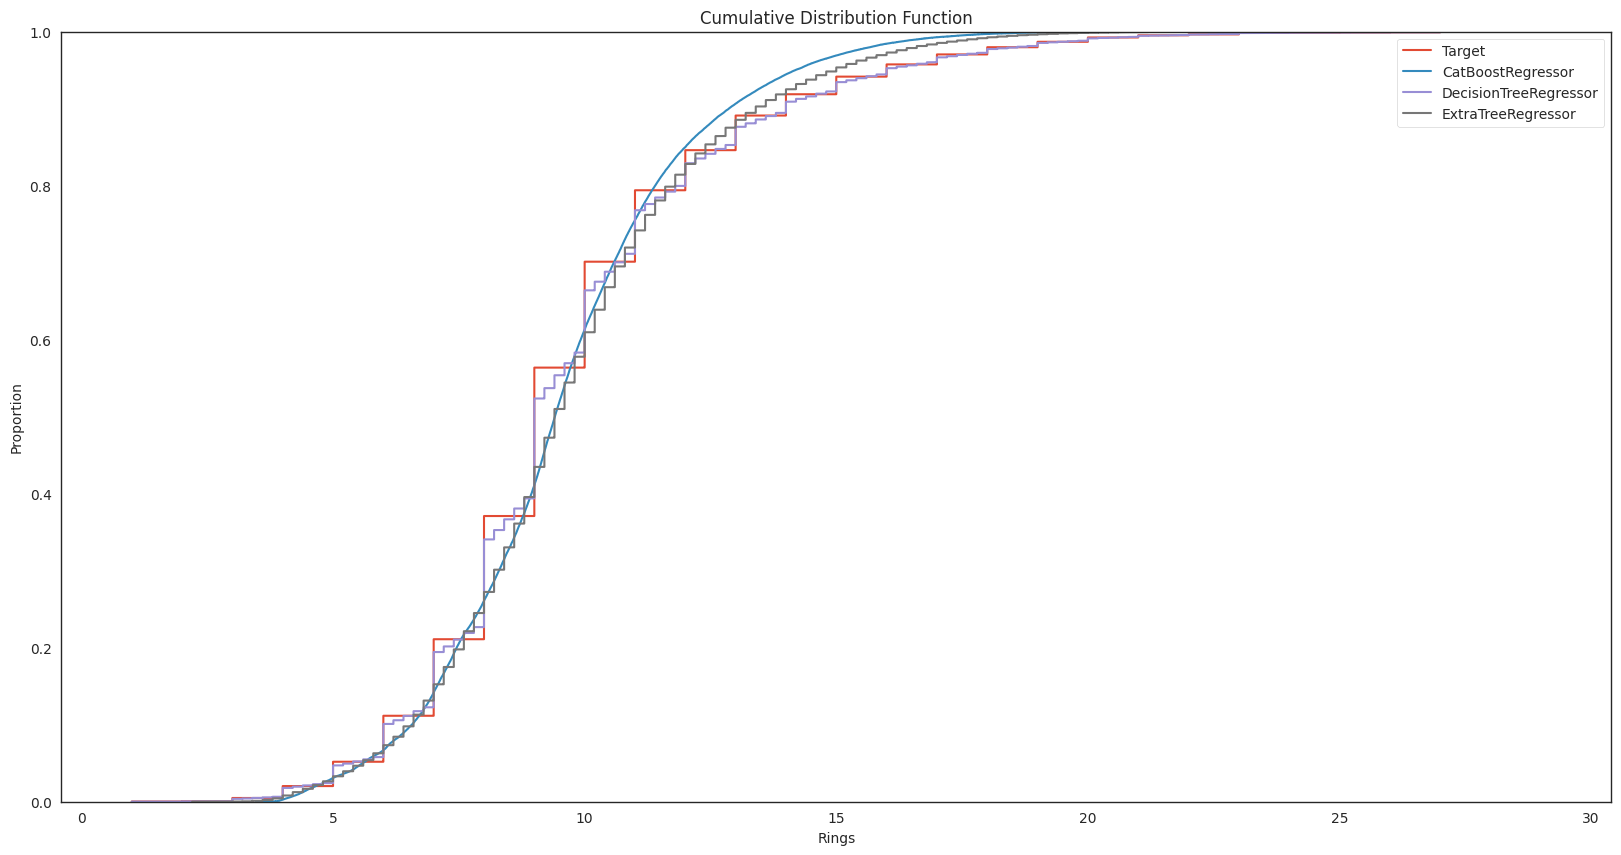

In [20]:
sns.set_style("white")
fig = plt.figure(figsize=[20, 10])

sns.ecdfplot(data=y, stat='proportion', complementary=False, label='Target')
for model, preds in model_preds.items():
    if model in ['CatBoostRegressor', 'DecisionTreeRegressor', 'ExtraTreeRegressor']:
        sns.ecdfplot(data=preds, stat='proportion', complementary=False, label=model)

plt.title('Cumulative Distribution Function', fontsize=12)
plt.xlabel('Rings', fontsize=10)
plt.ylabel('Proportion', fontsize=10)
plt.legend()
plt.show()